In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchaudio
from IPython.display import Audio
%matplotlib widget

In [33]:
files = [
    # "glowTTS/enc768/with_sigma/silence_preprocessed",
    # "glowTTS/enc768/with_sigma/not_silence_preprocessed",
    # "glowTTS/enc768/mean_only/not_silence_preprocessed",
    # "glowTTS/enc192/100ep/not_silence_preprocessed",
    # "glowTTS/enc192/200ep/long_cooldown/silence_preprocessed",
    "glowTTS/enc192/200ep/long_cooldown/not_silence_preprocessed",
    "glowTTS_simple_encoder/silence_preprocessed",
    # "glowTTS_nar_taco_encoder/silence_preprocessed",
    "glowTTS_nar_taco_encoder/not_silence_preprocessed",
    # "glowTTS_nar_taco_encoder_no_blstm/silence_preprocessed",
    # "glowTTS_nar_taco_encoder_no_blstm_16blocks/silence_preprocessed"
]

In [34]:
names = [
    "192-channel encoder",
    # "192-channel encoder",
    "only_project",
    "CNN + BLSTM encoder",
    "192-channel encoder Z-Space"
]

In [35]:
comparison = []

In [36]:
for f in files:
    comparison.append(h5py.File(f"/u/lukas.rilling/experiments/glow_tts_asr_v2/output/experiments/librispeech/tts_architecture/glow_tts/raw_audio/{f}/forward_spectrograms/spectrograms", "r"))

In [37]:
latent_space = h5py.File("/u/lukas.rilling/experiments/glow_tts_asr_v2/latent_space_glow192_200ep.hdf", "r")
comparison.append(latent_space)

In [38]:
z = torch.Tensor(latent_space["inputs"][:latent_space["seqLengths"][0][0]])
z.mean(), z.max(), z.min()

(tensor(-0.0018), tensor(5.2723), tensor(-5.4625))

In [39]:
gt_outputs = h5py.File("/u/lukas.rilling//experiments/glow_tts_asr_v2/output/experiments/librispeech/tts_architecture/glow_tts/ground_truth/ground_truth/forward_spectrograms/spectrograms", "r")
gt_outputs.keys()

<KeysViewHDF5 ['inputs', 'labels', 'seqLengths', 'seqTags']>

In [40]:

def get_spec_for_index(specs, lengths, index):
    start = 0
    end = 0
    for i in range(index+1):
        start = end
        end += lengths[i]
    return specs[start:end].T

In [41]:
index = 5
specs = []
for c in comparison:
    specs.append(get_spec_for_index(c["inputs"], c["seqLengths"][:, 0], index))

specs.append(get_spec_for_index(gt_outputs["inputs"], gt_outputs["seqLengths"][:, 0], index))

In [42]:
def plot_spec(ax, spec):
    shape = spec.shape
    x = np.arange(0, shape[0]+1)
    y = np.arange(0, shape[1]+1)

    ax.pcolormesh(spec[:, :shape[1]])


In [43]:
lengths = [s.shape[1] for s in specs]
max_length = max(lengths)
min_length = min(lengths)

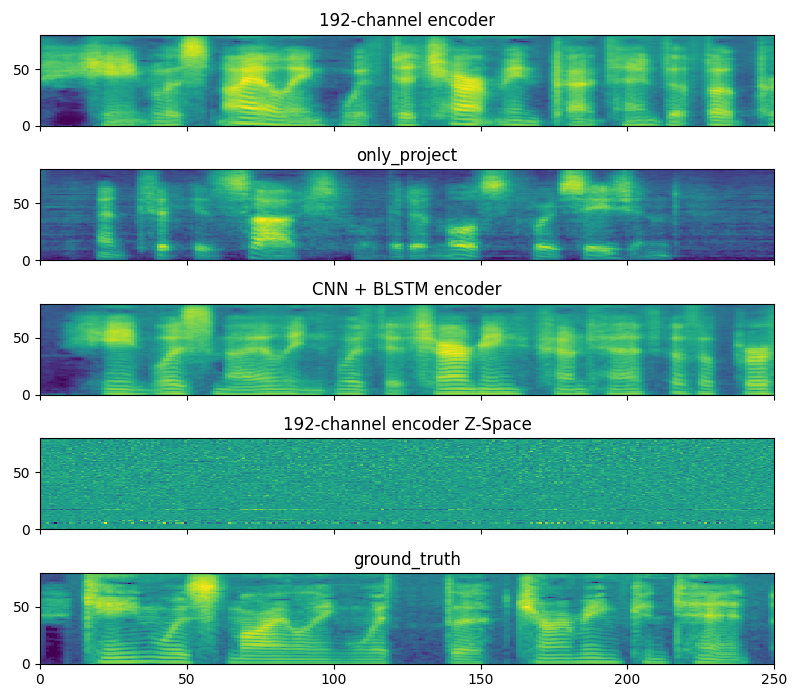

In [44]:
fig, axes = plt.subplots(len(specs), 1, sharex=True, figsize=[8,7])
for i,s in enumerate(specs):
    # plot_spec(axes[i], s)
    plot_spec(axes[i], s[:, :250])
    if i < len(specs) - 1:
        # title = names[files[i]] if files[i] in names.keys() else files[i]
        axes[i].set_title(names[i])
    else:
        axes[i].set_title("ground_truth")
# plot_spec(ax1, spec[:, :length])
# plot_spec(ax2, comp_spec[:, :length])
# plot_spec(ax3, gt_spec[:, :length])
fig.tight_layout(pad=0.9)
plt.show()


In [45]:
def plot_waveform(waveform, sample_rate=16000, title="Waveform", xlim=None, ylim=None):
#   waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

In [46]:
def inv_preemphasis(wav, preemphasis):
        """
        :param np.array wav:
        :param float k:
        :return:
        """
        from scipy import signal
        return signal.lfilter([1], [1, -preemphasis], wav)

In [47]:
def get_waveform_of_spec(spec):
    norm_std_dev = 30.906690797087478
    norm_mean = -76.49818038940428

    # s = spec.detach().cpu().numpy()
    s = spec.copy()
    print(np.min(s), np.max(s))
    s *= norm_std_dev
    s += norm_mean
    s /= 20
    s = np.power(10,s)
    print(np.min(s), np.max(s))
    num_freq = 1024
    iverse_mel = torchaudio.transforms.InverseMelScale(num_freq // 2 + 1, 80, f_min=60, f_max=7600, sample_rate=16000)
    spec_tensor = torch.Tensor(s)
    power_spec = iverse_mel(spec_tensor)
    
    power_spec[:5,:] = 0
    power_spec[-55:,:] = 0
    plot_spec(power_spec)
    print(torch.sum(power_spec, 1))
    print(f"spec.shape: {spec.shape}")
    print(f"power_spec.shape: {power_spec.shape}")
    griffin_lim = torchaudio.transforms.GriffinLim(num_freq, n_iter=60, win_length=int(0.05*16000), hop_length=int(0.0125*16000))

    wave = griffin_lim(power_spec)
    wave = wave.unsqueeze(0)
    wave = inv_preemphasis(wave, 0.97)
    plot_waveform(wave)
    return Audio(wave, rate=16000)


In [48]:
# get_waveform_of_spec(spec)


In [49]:
# get_waveform_of_spec(gt_spec)